In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
from pprint import pprint
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 6

warnings.filterwarnings('ignore')

Using device:  cuda:0


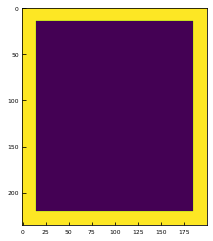

In [2]:
from morphogenesis.flow_networks.translation_models import MaskedVAE

model = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('tb_logs/edge_mask/MaskedVAE_sqh_beta=0.0001_split=embryo')

model.load_state_dict(info['state_dict'])
model.to(device)

plt.imshow(model.mask.detach().cpu().numpy())


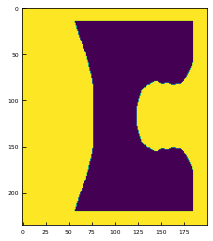

In [3]:
from morphogenesis.flow_networks.translation_models import MaskedVAE

model = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('tb_logs/pmg_cf_mask/MaskedVAE_sqh_beta=0.0001_split=embryo')
model.load_state_dict(info['state_dict'])
model.to(device)

plt.imshow(model.mask.detach().cpu().numpy())


1.3443583846092226 0.12199369465049945 0.02674381956862098 1.182118379756024 0.38049031090881014


100%|██████████| 6/6 [00:00<00:00, 308.66it/s]


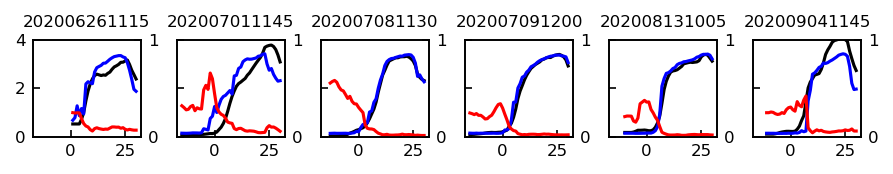

In [5]:
from flow_dataset import *
from morphogenesis.flow_networks.translation_models import MaskedVAE
from morphogenesis.plot_utils import *

def residual(u, v):
    '''
    We assume u is the INPUT and v is the TARGET
    Using residual metric from Sebastian's eLife paper to track how flow configuration is predicted
    '''
    umag = np.linalg.norm(u, axis=-3)
    vmag = np.linalg.norm(v, axis=-3)

    uavg = np.sqrt(np.mean(umag**2, axis=(-2,-1), keepdims=True))
    vavg = np.sqrt(np.mean(vmag**2, axis=(-2,-1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    denom = 2 * vavg**2 * uavg**2
    denom[denom == 0] += 1
    res /= denom
    return res.mean(axis=(1,2))

model = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('tb_logs/edge_mask/MaskedVAE_sqh_beta=0.01_split=embryo')
print(info['loss'], info['res'], info['res_std'], info['mse'], info['mse_std'])
model.load_state_dict(info['state_dict'])
model.eval()
model.to(device)


dataset = FlowDataset()
embryos = dataset.df.embryoID.unique()
fig, ax = plt.subplots(1, len(embryos), dpi=150, 
                       sharex=True, sharey=True, figsize=(len(embryos), 1.2))

for i, eId in enumerate(embryos):
    m, v0, t = dataset.get_trajectory(eId)
    m = torch.FloatTensor(m).to(device).reshape([-1, 4, 236, 200])
    v1, _ = model(m)
    v1 = v1.detach().cpu().numpy()

    v_nrm = np.linalg.norm(v0, axis=1).mean(axis=(1,2))
    ax[i].plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1,2)), color='black')
    ax[i].plot(t, np.linalg.norm(v1, axis=1).mean(axis=(1,2)), color='blue')
    
    
    ax[i].set_title(eId)

    ax2 = ax[i].twinx()
    ax2.plot(t, residual(v0, v1), color='red')
    ax2.set_ylim([0, 1])
    ax2.set_yticks([0, 1])

ax[0].set_ylim([0, 4])

plt.tight_layout()